In [144]:
import pickle
import os
import sys

In [146]:
from collections import defaultdict
from utils.dict_utils import dict_to_defaultdict
from utils.data_loaders import get_shape

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [174]:
dataset = 'cifar2_binary' # 'cifar2_binary', 'mnist'
num_classes = get_shape(dataset)[-1]
train_size = 1000 # 1000, 10000, 60000
num_hidden = 1 # 1, 2, 3
bias = False
normalization = 'none'
activation = 'lrelu'
optimizer = 'sgd' # 'sgd', 'rmsprop'
optimizer_name = 'GD' if optimizer == 'sgd' else 'RMSProp' if optimizer == 'rmsprop' else optimizer
num_seeds = 5
num_epochs = 50 # 5, 10, 50
batch_size = 1000 # 100, 1000
lr = 0.0002 # 0.02, 0.0002

In [175]:
log_dir = os.path.join(
    'results', 'epoch_dependence', '{}_{}'.format(dataset, train_size), 
    'num_hidden={}_activation={}_bias={}_normalization={}'.format(num_hidden, activation, bias, normalization), 
    '{}_lr={}_batch_size={}_num_epochs={}'.format(optimizer, lr, batch_size, num_epochs)
)
log_dir

'results/epoch_dependence/cifar2_binary_1000/num_hidden=1_activation=lrelu_bias=False_normalization=none/sgd_lr=0.0002_batch_size=1000_num_epochs=50'

In [176]:
results_all_path = os.path.join(log_dir, 'results_all.dat')
results_all = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: np.nan))))))
if os.path.exists(results_all_path):
    with open(results_all_path, 'rb') as f:
        results_all = dict_to_defaultdict(pickle.load(f), results_all)

In [163]:
correction_epochs = [0]
if num_hidden == 1:
    real_widths = [128, 65536]
    scaling_modes = ['mean_field', 'ntk', 'intermediate_q=0.75', 'default']
    scaling_mode_names = ['MF limit', 'NTK limit', r'intermediate limit; $q_\sigma=-3/4$', 'default']
    ref_widths = [128]
elif num_hidden == 2:
    real_widths = [16384]
    scaling_modes = ['mean_field', 'ntk', 'default']
    ref_widths = [128]
else:
    real_widths = [8192]
    scaling_modes = ['mean_field', 'ntk', 'default']
    ref_widths = [128]
    

In [152]:
plt.rcParams.update({'font.size': 18})

In [153]:
def ewma(a, alpha):
    av_a = a
    for i in range(1, len(a)):
        av_a[i] = a[i] * alpha + av_a[i-1] * (1-alpha)
    return av_a

In [154]:
def draw_curve(scaling_mode, ref_width, real_width, correction_epoch, key, 
               idx=None, threshold=1000, smoothening_factor=0, **kwargs):
    data = [
        [
            results_all[scaling_mode][ref_width][correction_epoch][real_width][seed][key][epoch] 
            for epoch in range(num_epochs)
        ] for seed in range(num_seeds)
    ]
    data = np.array(data)
    data = np.clip(data, -threshold, threshold)
    data = np.exp(ewma(np.log(data.T)[::-1], alpha=1-smoothening_factor)[::-1].T)
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    plt.plot(np.arange(1, num_epochs+1), data_mean, **kwargs)
    plt.fill_between(
        np.arange(1, num_epochs+1),
        data_mean - data_std, data_mean + data_std,
        alpha=0.3, **kwargs
    )
        

In [155]:
linestyles = ['solid', 'dashed', 'dotted', 'dashdot', (0, (1,5)), (0, (3,5))]
cmap = plt.get_cmap('tab10')
key_bases = ['test_losses', 'test_accs', 'train_losses', 'train_accs']
key_modifiers = [('', '')]
ylims = [(0.64,0.72), (0.8, 0.9), (0.6,0.7), (0.7,1.0)]

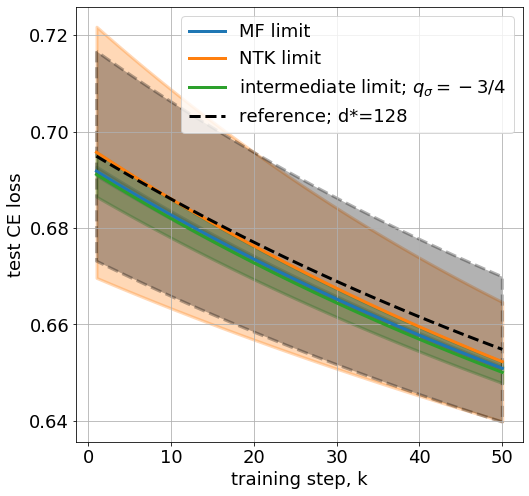

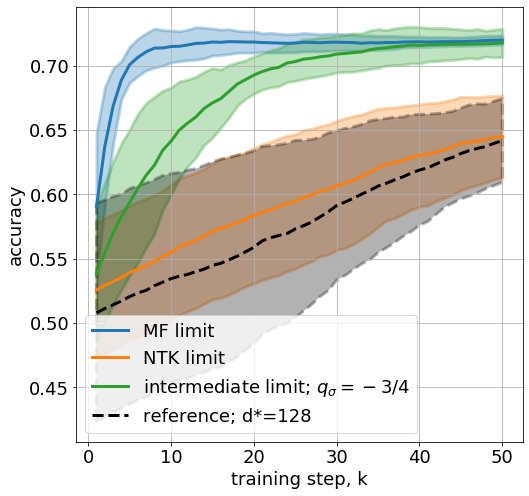

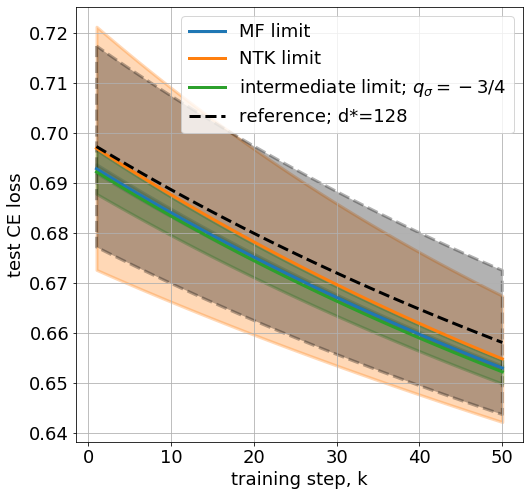

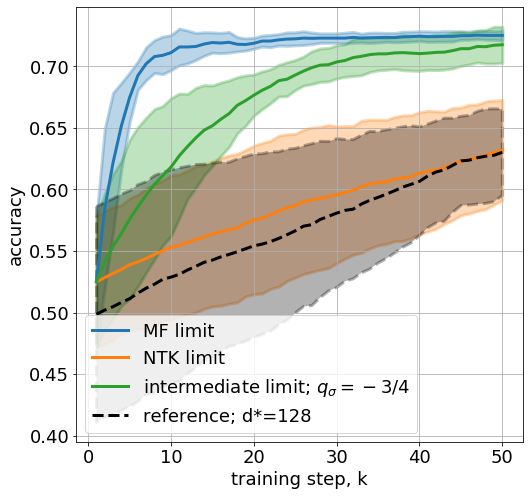

In [177]:
for key_base, ylim in zip(key_bases, ylims):
    _ = plt.figure(figsize=(8,8))

    plt.xlabel('training step, k')
    # plt.ylim(ylim) # uncomment to adjust y-limits manually
    plt.grid(True)

    if key_base.endswith('_losses'):
        plt.ylabel("test CE loss")
    elif key_base.endswith('_accs'):
        plt.ylabel("accuracy")

    for ref_width in ref_widths:
        for real_width in real_widths[::-1]:
            for k, scaling_mode in enumerate(scaling_modes):
                if (ref_width == real_width) != (scaling_mode == 'default'):
                    continue
                for correction_epoch in (
                    correction_epochs if scaling_mode.startswith('mean_field') else [None]
                ):
                    if correction_epoch == 0 and scaling_mode == 'mean_field_var1':
                        continue
                    for i, key_mod in enumerate(key_modifiers):
                        key = key_mod[0] + key_base + key_mod[1]
                        if scaling_mode == 'default':
                            draw_curve(
                                scaling_mode, None, 
                                real_width, correction_epoch, key, color='black', 
                                linestyle='dashed', lw=3
                            )
                        else:
                            draw_curve(
                                scaling_mode, ref_width, 
                                real_width, correction_epoch, key, color=cmap(k), 
                                linestyle=linestyles[i], lw=3
                            )
                    
    plt.legend(
        scaling_mode_names[:-1] + ['reference; d*={}'.format(ref_widths[0])]
    )
    plt.show()